# Тут собран основной код для генерации фичей по графу поставщиков, а также его первичный анализ  

## скачиваем данные

In [2]:
!gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
!gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
!gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
!gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
!gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

Downloading...
From: https://drive.google.com/uc?id=1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
To: /content/graph.csv
100% 5.75M/5.75M [00:00<00:00, 222MB/s]
Downloading...
From: https://drive.google.com/uc?id=12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
To: /content/submission.csv
100% 131k/131k [00:00<00:00, 45.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
To: /content/test2_X.csv
100% 40.0M/40.0M [00:00<00:00, 64.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
To: /content/train_X.csv
100% 87.8M/87.8M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo
To: /content/train_y.csv
100% 514k/514k [00:00<00:00, 34.9MB/s]


In [3]:
%pip install pyvis torch_geometric >> None

In [4]:
# other
from itertools import combinations, groupby
from tqdm import tqdm

# for graphs
from torch_geometric.utils import from_networkx
from torch_geometric.data import Batch

import networkx as nx
import torch_geometric.transforms as T

# for data
import pandas as pd
import numpy as np

# for visualazing
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.impute import SimpleImputer

### Считывем граф и производим стандартную предобработку табличных данных

In [5]:
data_path = '/content'
graph = pd.read_csv(f'{data_path}/graph.csv').drop(columns=['Unnamed: 0'])

In [6]:
def preprocess_data(
    train,
    test,
    delete_corr_features=True,
    scale=True,
    init_features2drop=None,
    cat_features=[]
  ):

    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/4))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            train_imputer = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = train_imputer.transform(train[col].values.reshape(-1, 1))
            test[col] = train_imputer.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns

    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])

    if init_features2drop is not None:
      train = train.drop(columns=init_features2drop)
      test = test.drop(columns=init_features2drop)

    return train, test, constant_features_names

In [7]:
root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

y_train_all = train["default6"]

In [8]:
for_drop = ["project_id", "building_id", "specialization_id"]
cat_features = [ "report_date_day", "report_date_month", "contract_date_day", "contract_date_month"]

train, test, constant_features_names = preprocess_data(
    train.copy(),
    test.copy(),
    delete_corr_features=False,
    scale=False,
    init_features2drop=for_drop,
)

## Тут предобработка самого графа, а именно удаление полных дубликатов рёбер, например (u, v, w) и (v, u, w)

In [9]:
graph_inversed = graph.copy()
tmp = graph_inversed['contractor_id1']
graph_inversed['contractor_id1'] = graph_inversed['contractor_id2']
graph_inversed['contractor_id2'] = tmp
graph_inversed['base_graph'] = 1
graph['base_graph'] = 0

In [10]:
graph_joined = pd.concat([graph, graph_inversed], axis=0)

In [11]:
graph_joined = graph_joined.drop_duplicates(subset=['contractor_id1', 'contractor_id2', 'Distance'])
graph = graph_joined[graph_joined['base_graph'] == 1].drop(columns='base_graph')

# Небольшой EDA

*для начала заметим что не все поставщики из таблиц, есть а графе и наоборот*

In [18]:
print(
    "Кол-во поставщиков, которые есть и в трейне/тесте, и в графе:",  len((
        set(train['contractor_id'].unique()) | set(test['contractor_id'].unique())
    ) & (
        set(graph['contractor_id1'].unique()) | set(graph['contractor_id2'].unique())
    ))
)
print("Кол-во поставщиков в графе:", len(
        set(graph['contractor_id1'].unique()) | set(graph['contractor_id2'].unique())
    ),
)
print(
    "Кол-во поставщиков в трейне/тесте:", len(
        set(train['contractor_id'].unique()) | set(test['contractor_id'].unique())
    )
)

Кол-во поставщиков, которые есть и в трейне/тесте, и в графе: 764
Кол-во поставщиков в графе: 803
Кол-во поставщиков в трейне/тесте: 847


*Посмотрим сколько всего рёбер после пропроцессинга*

In [29]:
print("Всего рёбер:", graph.shape[0])
print("У полного графа на 803 вершинах:", 803 * 802 / 2)
print("Значит что граф почти полносвязнный, а ещё значит, что он направленный либо есть рёбра разных типов")
print("Для таких графов лучше использовать Гетерогенные графы, но пока что мы не успели это как-то проработать")

Всего рёбер: 316814
У полного графа на 803 вершинах: 322003.0
Значит что граф почти полносвязнный, а ещё значит, что он направленный либо есть рёбра разных типов
Для таких графов лучше использовать Гетерогенные графы, но пока что мы не успели это как-то проработать


## Создаем граф с помощью networkx

In [22]:
def creat_nx_graph(graph):
  G = nx.Graph()

  pairs = []
  for _, row in tqdm(graph.iterrows()):
    pairs.append((int(row['contractor_id1']), int(row['contractor_id2']), int(row['Distance'])))

  G.add_weighted_edges_from(pairs)
  return G

def vis_graph(G):

  pos = nx.spring_layout(G)
  nx.draw(
      G,
      pos,
      with_labels=False,
      node_color='lightblue',
      node_size=100,
      edge_color='gray'
  )

  plt.title("Пример подграфа")
  plt.show()


*Попробуем просто насэмплить 10 рандомных нод и визуализировать это, посмотреть как они связаны между собой*

44it [00:00, 11422.26it/s]


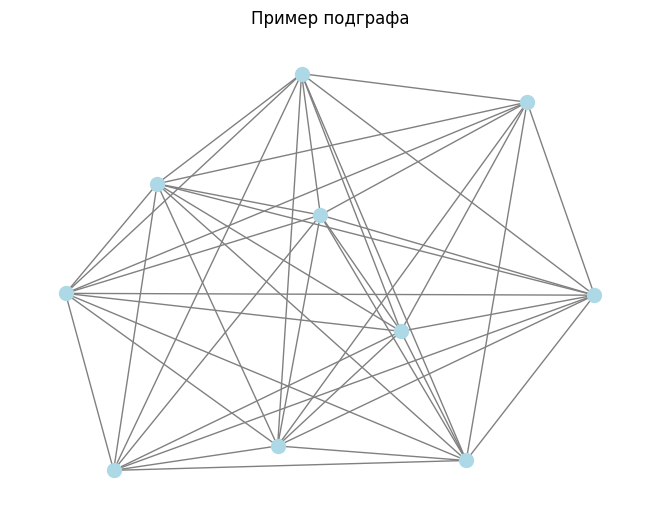

In [30]:
rnd_nodes = np.random.choice(
    graph['contractor_id1'].unique(),
    size=10,
    replace=False
)

subgraph = graph[graph['contractor_id1'].isin(rnd_nodes) & graph['contractor_id2'].isin(rnd_nodes)]
subG = creat_nx_graph(subgraph)
vis_graph(subG)
#Видно, что нет чёткой структуры, но при этом почти все со всеми связаны

*Теперь провизуализируем подграф таким образом -> возьмём произвольную ноду, а дальше возьмём топ 10 самых близких к ней, таким образом попробуем найти какую-то структуру*

31it [00:00, 3467.01it/s]


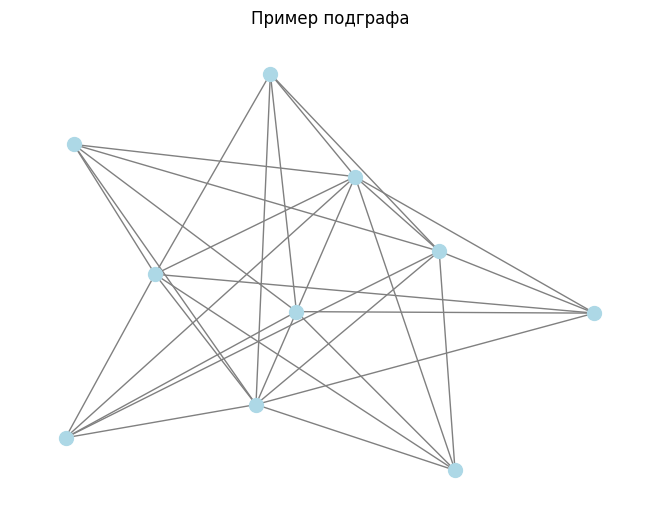

In [37]:
rnd_node = np.random.choice(
    graph['contractor_id1'].unique(),
    size=1,
)

best_neighs = graph[graph['contractor_id1'] == rnd_node[0]].sort_values('Distance', ascending=False).iloc[:10]['contractor_id2'].values
subgraph = graph[graph['contractor_id1'].isin(best_neighs) & (graph['contractor_id2'].isin(best_neighs))]
subG = creat_nx_graph(subgraph)
vis_graph(subG)
# Так же нельзя выделить какую-то чёткую структуру

# Feature Generation

In [ ]:
G = creat_nx_graph(graph)

## Тут генерируем базовые фичи, аггрегации дистанций по поставщикам

In [ ]:
if gen_distance_features := True:
  graph_distaces_features = graph_joined.groupby(['contractor_id1'], as_index=False)['Distance'].agg(['mean', 'std', 'median']).rename({'contractor_id1' : 'contractor_id'}, axis=1)
  graph_distaces_features.columns = [graph_distaces_features.columns[0]] + [f'contractor_distance_{col}' for col in graph_distaces_features.columns[1:]]
  graph_distaces_features.to_csv('contractor_distances_features.csv', index=False)

## Тут генерация фичей поинтереснее, например меры центральности, pagerank и т.д.

In [1]:
#вторая версия фичей
def compute_graph_node_features_v2(G):

  from networkx.algorithms import community

  print('precomputing some features for all nodes')
  degree_dict = dict(G.degree())

  weighted_degree_dict = dict(G.degree(weight='weight'))
  degree_centrality = nx.degree_centrality(G)
  max_weighted_degree = max(weighted_degree_dict.values())
  weighted_degree_centrality = {node: wd / max_weighted_degree for node, wd in weighted_degree_dict.items()}
  betweenness_centrality = nx.betweenness_centrality(G)
  closeness_centrality = nx.closeness_centrality(G, distance='weight')
  print(2)
  eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
  print(3)
  pagerank = nx.pagerank(G, weight='weight')
  print(4)
  clustering_coeff = nx.clustering(G, weight='weight')
  print(5)
  triangles = nx.triangles(G)
  print(6)
  eccentricity = nx.eccentricity(G)
  print(7)
  hubs, authorities = nx.hits(G)
  print(8)
  load_centrality = nx.load_centrality(G, weight='weight')
  print(9)
  current_flow_betweenness_centrality = nx.current_flow_betweenness_centrality(G, weight='weight')
  current_flow_closeness_centrality = nx.current_flow_closeness_centrality(G, weight='weight')

  all_pairs_shortest_path = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

  edge_betweenness = nx.edge_betweenness_centrality(G, weight='weight')

  communicability = nx.communicability(G)

  node_features = {}

  for node in tqdm(G.nodes()):
      node_features[node] = {
          'degree': degree_dict[node],
          'weighted_degree': weighted_degree_dict[node],
          'weighted_degree_centrality': weighted_degree_centrality[node],
          'degree_centrality': degree_centrality[node],
          'betweenness_centrality': betweenness_centrality[node],
          'closeness_centrality': closeness_centrality[node],
          'eigenvector_centrality': eigenvector_centrality[node],
          'pagerank' : pagerank[node],
          'clustering_coeff' : clustering_coeff[node],
          'eccentricity' : eccentricity[node],
          'hubs' : hubs[node],
          'authorities' : authorities[node],
          'load_centrality' : load_centrality[node],
          'current_flow_betweenness_centrality' : current_flow_betweenness_centrality[node],
          'current_flow_closeness_centrality' : current_flow_closeness_centrality[node]
      }

  return node_features

# 3-я версия - тут более кастомизированная версия
def compute_graph_node_features_v3(G):

  print('computing harder feature')

  all_pairs_shortest_path = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))

  edge_betweenness = nx.edge_betweenness_centrality(G, weight='weight')

  communicability = nx.communicability(G)

  node_features = {}

  for node in tqdm(G.nodes()):
      node_features[node] = {}

      mean_length_shortest_path = 0
      for neightbour in all_pairs_shortest_path[node].keys():
        mean_length_shortest_path += len(all_pairs_shortest_path[node][neightbour])
      node_features[node]['mean_length_shortest_path'] = mean_length_shortest_path / len(all_pairs_shortest_path[node].keys())

      mean_edge_betweenness = 0
      count = 0
      for key, value in edge_betweenness.items():
        if node in key:
          mean_edge_betweenness += value
          count += 1
      node_features[node]['mean_edge_betweenness'] = mean_edge_betweenness / count

      communicabilities = list(communicability[node].values())
      node_features[node]['mean_communicability'] = np.mean(communicabilities)
      node_features[node]['max_communicability'] = np.max(communicabilities)
      node_features[node]['median_communicability'] = np.median(communicabilities)
      node_features[node]['max_communicabity_c_id'] = sorted(communicability[node].items(), key=lambda x: x[1])[-1][0]

  return node_features


# Самая простая версия
def compute_graph_node_features_v1(G):

  node_features = {}

  print('precomputing some features for all nodes')
  degree_centrality = nx.degree_centrality(G)
  closeness_centrality = nx.closeness_centrality(G)
  betweenness_centrality = nx.betweenness_centrality(G)
  eigenvector_centrality = nx.eigenvector_centrality(G)
  print('Computing PageRank')
  pagerank = nx.pagerank(G)

  print('starting computing single node features')
  for node in tqdm(G.nodes()):
      node_features[node] = {
          'Degree': G.degree(node),
          'Degree Centrality': degree_centrality[node],
          'Closeness Centrality': closeness_centrality[node],
          'Betweenness Centrality': betweenness_centrality[node],
          'Eigenvector Centrality': eigenvector_centrality[node],
          'Clustering Coefficient': nx.clustering(G, node),
          'PageRank': pagerank[node],
      }

  return node_features

# Тут просто получаем k соседей и записыаем их id
def get_k_neighbors(G, k):

  node_features = {}

  for node in tqdm(G.nodes()):
     neighbors = list(G.neighbors(node))
     neighbors_ws = {nei : G[node][nei]['weight'] for nei in neighbors}
     neighbors_ws = sorted(neighbors_ws.items(), key=lambda x: x[1], reverse=False)[:k]
     node_features[node] = {}
     for i, (nei, wei) in enumerate(neighbors_ws):
      node_features[node][f"top_{i}_id"] = nei
      node_features[node][f"top_{i}_id_distance"] = wei

  return node_features

In [ ]:
nodes_neigbors = get_k_neighbors(G, 5)

100%|██████████| 803/803 [00:02<00:00, 312.43it/s]


## Генерируем фичи для ребёр чтобы потом саггрегировать по поставщикам

In [ ]:
def generate_edge_features(G):

  edge_features = pd.DataFrame(columns=[
          'u',
          'v',
          'jaccard',
          'adamic_adar',
          'prefer_attach',
          'resource_alloc',
          'source_pagerank',
          'target_pagerank',
          'edge_weight_ratio'
      ])

  print(2)
  pagerank = nx.pagerank(G, weight='weight')

  print(6)
  max_weight = max([data['weight'] for u, v, data in G.edges(data=True)])
  avg_weight = sum([data['weight'] for u, v, data in G.edges(data=True)]) / G.number_of_edges()

  print(7)
  for u, v, data in tqdm(G.edges(data=True)):
      weight = data.get('weight', 1.0)
      jaccard = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
      adamic_adar = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
      prefer_attach = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
      resource_alloc = list(nx.resource_allocation_index(G, [(u, v)]))[0][2]
      source_pagerank = pagerank.get(u, 0)
      target_pagerank = pagerank.get(v, 0)
      edge_weight_ratio = weight / max_weight if max_weight != 0 else 0
      edge_features = pd.concat([pd.DataFrame({
          'u': [u],
          'v': [v],
          'weight': [weight],
          'jaccard': [jaccard],
          'adamic_adar': [adamic_adar],
          'prefer_attach': [prefer_attach],
          'resource_alloc': [resource_alloc],
          'source_pagerank': [source_pagerank],
          'target_pagerank': [target_pagerank],
          'edge_weight_ratio': [edge_weight_ratio]
      }), edge_features], ignore_index=True)

  return edge_features

In [ ]:
edge_features = generate_edge_features(G)

## Ещё одна версия генерации фичей -> усреднение с весами признаков от top k соседей

In [ ]:
from statistics import mode

#нужно
graph_features_v2 = pd.read_csv("contractor_graph_features_v2.csv")
graph_features_v3 = pd.read_csv("contractor_graph_features_v3.csv")
all_graph_features_v2_v3 = [col for col in list(graph_features_v2.columns) + list(graph_features_v3.columns) if col != 'contractor_id']

def generate_features_v4(
    G,
    train_test,
    top_k=None,
    k_const=None,
    columns=[],
    cat_features=[]
  ):

  nodes_features = {}

  precomputed_contractor_features = train_test.groupby(
      'contractor_id'
  )[columns].agg(['mean'])
  precomputed_contractor_cat_features = train_test.groupby(
      'contractor_id'
  )[cat_features].agg(lambda x: mode(x))

  precomputed_contractor_features.columns = [f"{col[0]}_{col[1]}" for col in precomputed_contractor_features.columns]

  precomputed_contractor_cat_features.columns = [f"{col}_mode" for col in precomputed_contractor_cat_features.columns]

  for node in tqdm(G.nodes()):

      nodes_features[node] = {}
      neighbors = list(G.neighbors(node))
      neighbors_weights = {nei : G.get_edge_data(node, nei)['weight'] for nei in neighbors}
      neighbors_weights = sorted(neighbors_weights.items(), key = lambda x: x[1])
      weights = []

      for i, (nei, w) in enumerate(neighbors_weights[::-1]):

        if nei in list(precomputed_contractor_features.index):

          if (top_k is not None and i + 1 > top_k): break
          if (k_const is not None and w < k_const): break

          weights.append(w)

          for col in columns:

            if col not in cat_features:
              nodes_features[node][f'{col}_mean'] = nodes_features[node].get(f'{col}_mean', []) + \
                  [precomputed_contractor_features.loc[nei][f'{col}_mean'] * w]

            else:
              nodes_features[node][f'{col}_mode'] = nodes_features[node].get(f'{col}_mode', []) + \
                  [precomputed_contractor_cat_features.loc[nei][f'{col}_mode']]


      for col in columns:

          if col not in cat_features:

            nodes_features[node][f'{col}_mean'] = np.sum(nodes_features[node][f'{col}_mean']) / np.sum(weights)

          else:

            nodes_features[node][f'{col}_mode'] = mode(nodes_features[node][f'{col}_mode'])

  return nodes_features

In [ ]:
test['default6'] = 0

train_test = pd.concat([train, test], axis=0)

neigbors_features = generate_features_v4(
    G,
    train_test,
    top_k=5,
    columns=[
        col for col in train_test.columns \
        if col not in [
            'contract_id',
            'contractor_id',
            'default6',
            # 'report_date_day',
            # 'report_date_month',
            # 'contract_date_day',
        ]
    ],
    cat_features=cat_features,
)

### Сохранение фичей

In [ ]:
import pickle

with open('/content/edge_features.pickle', 'wb') as f:
  pickle.dump(edge_features, f)

In [ ]:
def save_features(features, file_name, do_not_add=[]):
  nodes_features_lists = {key : [] for key in ['contractor_id'] + list(features[0].keys())}

  for c_id, n_feats in tqdm(iter(features.items())):
    nodes_features_lists['contractor_id'].append(c_id)
    for feat_name, feat_value in n_feats.items():
        nodes_features_lists[feat_name].append(feat_value)

  graph_nodes_features = pd.DataFrame(nodes_features_lists)
  graph_nodes_features.drop(
      columns=[col for col in graph_nodes_features.columns if col[:-5] in do_not_add],
      inplace=True
  )

  graph_nodes_features.to_csv(f'{file_name}.csv', index=False)

In [ ]:
datashifted_features = ['specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'building_id',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME'] + \
  ['agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_sroomer__g_contractor__sroomer_id__count__12M',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'building_id',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']

In [ ]:
save_features(neigbors_features, 'neigbors_top_5_delete_cols', do_not_add=datashifted_features)

In [ ]:
pd.read_csv("/content/neigbors_top_5_delete_cols.csv")